In [ ]:
## Experimental Setup

In [1]:
from fastai.vision import *
from fastai.distributed import *
from fastai.metrics import error_rate
from fastai.callbacks import SaveModelCallback

if torch.cuda.is_available():
  print("Great! Good to go!")
else:
  print('CUDA is not up!')

Great! Good to go!


In [2]:
# from gepcore.utils import cell_graph
# from gepnet.model_v2 import get_gepnet, arch_config
# from gepnet.utils import count_parameters
# torch.backends.cudnn.benchmark = True

from gepcore.utils import cell_graph, convolution
from gepcore.entity import Gene, Chromosome
from gepcore.symbol import PrimitiveSet
from gepnet.model_v1 import get_net, arch_config
from gepnet.utils import count_parameters
torch.backends.cudnn.benchmark = True

In [3]:
from pygraphviz import AGraph
import glob

In [4]:
graph = [AGraph(g) for g in glob.glob('comp_graphs/new/*.dot')]
_, comp_graph = cell_graph.generate_comp_graph(graph)#

In [9]:
# generate new chromosome
# define primitive set
pset = PrimitiveSet('cnn')

# add cellular encoding program symbols
pset.add_program_symbol(cell_graph.end)
pset.add_program_symbol(cell_graph.seq)
pset.add_program_symbol(cell_graph.cpo)
pset.add_program_symbol(cell_graph.cpi)

# add convolutional operations symbols
conv_symbol = convolution.get_symbol()
pset.add_cell_symbol(conv_symbol.conv3x3)
#pset.add_cell_symbol(conv_symbol.sepconv5x5)
#pset.add_cell_symbol(conv_symbol.dilconv3x3)
#pset.add_cell_symbol(conv_symbol.dilconv5x5)
pset.add_cell_symbol(conv_symbol.conv1x1)
pset.add_cell_symbol(conv_symbol.dwconv3x3)
#pset.add_cell_symbol(conv_symbol.maxpool3x3)

def gene_gen():
    return Gene(pset, 2)
ch = Chromosome(gene_gen, 4)
graph, comp_graph = cell_graph.generate_comp_graph(ch)

cell_graph.save_graph(graph, 'comp_graphs/new')
cell_graph.draw_graph(graph, 'comp_graphs/new')

In [5]:
# import random
seed = 200
# random.seed(seed)
# np.random.seed(seed)
# torch.manual_seed(seed)
# torch.cuda.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)

# # enable torch backends
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True
#torch.backends.deterministic = True

In [6]:
conf = arch_config(comp_graph=comp_graph,
                   #depth_coeff=1.0,
                   #width_coeff=1.0,
                   channels=40,
                   repeat_list=[3, 4, 3],
                   classes=10)

net = get_net(conf)
count_parameters(net)

3.78781

In [7]:
size=32
cutout_frac = 0.30
p_cutout = 0.75
cutout_sz = round(size*cutout_frac)
cutout_tfm = cutout(n_holes=(2,2), length=(cutout_sz, cutout_sz), p=p_cutout)

path = untar_data(URLs.CIFAR)
tfms = get_transforms(xtra_tfms=[cutout_tfm])#do_flip=False,
                      #xtra_tfms=[RandTransform(tfm=cutout, kwargs={'n_holes': (1,1)})])
bs =128
data = (ImageList.from_folder(path/'train')
        .split_by_rand_pct(valid_pct=0.1, seed=seed) 
        .label_from_folder()
        .transform(tfms, size=32)
        .databunch(bs=bs, num_workers=num_cpus())
        .normalize(cifar_stats))

In [8]:
#opt_func=optim.Adam,
model_dir = '/home/cliff/ResearchProjects/geppy_nn/comp_graphs/new'
learn = Learner(data, net, bn_wd=False, metrics=[error_rate, accuracy], model_dir=model_dir)#.mixup() 
learn.to_fp16()   

Learner(data=ImageDataBunch;

Train: LabelList (45000 items)
x: ImageList
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
y: CategoryList
automobile,automobile,automobile,automobile,automobile
Path: /home/cliff/.fastai/data/cifar10/train;

Valid: LabelList (5000 items)
x: ImageList
Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32),Image (3, 32, 32)
y: CategoryList
cat,cat,ship,ship,automobile
Path: /home/cliff/.fastai/data/cifar10/train;

Test: None, model=Network(
  (stem_): Sequential(
    (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (blocks_): Sequential(
    (0): Cell(
      (relu): ReLU(inplace=True)
      (branch_0): Layer(
        (conv1x1_0): Sequential(
          (0): Conv2d(40, 40, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, 

epoch,train_loss,valid_loss,error_rate,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


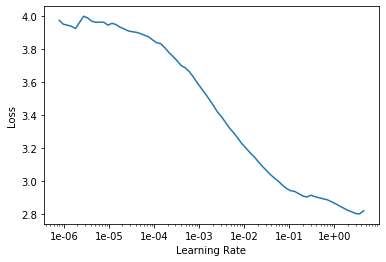

In [16]:
learn.lr_find(wd=4e-4,end_lr=100)
learn.recorder.plot()
#SGD(params, lr=<required parameter>, momentum=0, dampening=0, weight_decay=0, nesterov=False)

In [9]:
cb = SaveModelCallback(learn, every='improvement', monitor='accuracy', name='model_2')
learn.fit_one_cycle(1500, 3e-3, wd=0.0004, callbacks=[cb]) 

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.554363,1.557953,0.556200,0.443800,01:07
1,1.368053,1.311176,0.471600,0.528400,01:08
2,1.244355,1.201602,0.420000,0.580000,01:08
3,1.141673,1.066611,0.372600,0.627400,01:09
4,1.063274,1.015867,0.348000,0.652000,01:08
5,0.981949,0.891954,0.307600,0.692400,01:08
6,0.968433,0.910652,0.310800,0.689200,01:08
7,0.896409,0.863249,0.299200,0.700800,01:09
8,0.840841,0.774608,0.271200,0.728800,01:09
9,0.796669,0.744206,0.258200,0.741800,01:08


Better model found at epoch 0 with accuracy value: 0.4438000023365021.
Better model found at epoch 1 with accuracy value: 0.5284000039100647.
Better model found at epoch 2 with accuracy value: 0.5799999833106995.
Better model found at epoch 3 with accuracy value: 0.6273999810218811.
Better model found at epoch 4 with accuracy value: 0.6520000100135803.
Better model found at epoch 5 with accuracy value: 0.6923999786376953.
Better model found at epoch 7 with accuracy value: 0.7008000016212463.
Better model found at epoch 8 with accuracy value: 0.7287999987602234.
Better model found at epoch 9 with accuracy value: 0.7418000102043152.
Better model found at epoch 10 with accuracy value: 0.7486000061035156.
Better model found at epoch 11 with accuracy value: 0.7576000094413757.
Better model found at epoch 12 with accuracy value: 0.7752000093460083.
Better model found at epoch 13 with accuracy value: 0.782800018787384.
Better model found at epoch 14 with accuracy value: 0.8062000274658203.
Be

KeyboardInterrupt: 

In [ ]:
####################### Testing ###########################

In [16]:
graph_dir = 'comp_graphs/new/*.dot' #'/content/mnt/My Drive/Colab Notebooks/ResearchProject/comp_graphs/experiment_1/best/indv_1/*.dot'
graph = [AGraph(g) for g in glob.glob(graph_dir)]
_, comp_graph = cell_graph.generate_comp_graph(graph)

In [17]:
conf = arch_config(comp_graph=comp_graph,
                   #depth_coeff=1.0,
                   #width_coeff=1.0,
                   channels=40,
                   repeat_list=[3, 4, 3],
                   classes=10)

net = get_net(conf)
count_parameters(net)

3.78781

In [18]:
tfms = get_transforms(do_flip=False)
path = untar_data(URLs.CIFAR)
bs = 256

data = (ImageList.from_folder(path)
        .split_by_folder(train='train', valid='test')
        .label_from_folder()
        .transform(tfms, size=32)
        .databunch(bs=bs, num_workers=num_cpus())
        .normalize(cifar_stats))

In [19]:
model_dir = '/home/cliff/ResearchProjects/geppy_nn/comp_graphs/new' #'/content/mnt/My Drive/Colab Notebooks/ResearchProject/models/'
model = Learner(data, net, metrics=[accuracy, error_rate]).load(model_dir+'/model_1')
model.validate()

[0.1600816, tensor(0.9640), tensor(0.0360)]

In [ ]:
preds,y,losses = model.get_preds(ds_type=DatasetType.Valid, with_loss=True)
preds[:5]